In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os
from tqdm.notebook import tqdm
from scipy.integrate import solve_ivp
import scipy.stats as st
from sklearn.metrics import mean_squared_error,mean_squared_log_error
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
import time
from datetime import datetime, timedelta
from scipy import integrate, optimize
import seaborn as sns
import warnings
%matplotlib inline
warnings.filterwarnings("ignore")

In [2]:
path_dir = 'C:\\Users\\kumapank\\Documents\\COVID-19\\'

# Read Master Data

In [3]:
col_nm = ['Province/State','Country/Region','Lat','Long','Date','Value']
conf_df = pd.read_csv(path_dir+'\\input\\time_series_2019 Vertical Data\\time_series_covid19_confirmed_global_narrow.csv')
conf_df = conf_df[col_nm].drop(index=0).rename(index=str,columns={'Value':'Confirmed'})
dth_df = pd.read_csv(path_dir+'\\input\\time_series_2019 Vertical Data\\time_series_covid19_deaths_global_narrow.csv')
dth_df = dth_df[col_nm].drop(index=0).rename(index=str,columns={'Value':'Death'})
rcv_df = pd.read_csv(path_dir+'\\input\\time_series_2019 Vertical Data\\time_series_covid19_recovered_global_narrow.csv')
rcv_df = rcv_df[col_nm].drop(index=0).rename(index=str,columns={'Value':'Recovered'})
conf_df.Date = pd.to_datetime(conf_df.Date, format='%Y-%m-%d')
dth_df.Date = pd.to_datetime(dth_df.Date, format='%Y-%m-%d')
rcv_df.Date = pd.to_datetime(rcv_df.Date, format='%Y-%m-%d')

In [4]:
df = pd.merge(conf_df,dth_df,left_on=['Province/State','Country/Region','Lat','Long','Date'],right_on=['Province/State','Country/Region','Lat','Long','Date'],how='left')
df.columns = ['Province/State','Country/Region','Lat','Long','Date','Confirmed','Death']
df = pd.merge(df,rcv_df,left_on=['Province/State','Country/Region','Lat','Long','Date'],right_on=['Province/State','Country/Region','Lat','Long','Date'],how='left')
df.columns = ['Province/State','Country/Region','Lat','Long','Date','Confirmed','Death','Recovered']
df = df.sort_values(by=['Province/State','Country/Region','Date'], ascending=(True,True,True))
df.Confirmed = df.Confirmed.fillna(0)
df.Death = df.Death.fillna(0)
df.Recovered = df.Recovered.fillna(0)
df.Confirmed = df.Confirmed.astype(int)
df.Death = df.Death.astype(int)
df.Recovered = df.Recovered.astype(int)
df= df.groupby(by=['Country/Region','Date'])['Confirmed','Death','Recovered'].sum().reset_index()
df.head()

,Country/Region,Date,Confirmed,Death,Recovered
0,Afghanistan,2020-01-22,0,0,0
1,Afghanistan,2020-01-23,0,0,0
2,Afghanistan,2020-01-24,0,0,0
3,Afghanistan,2020-01-25,0,0,0
4,Afghanistan,2020-01-26,0,0,0


# Curve Fitting

In [5]:
# # mst_df['Area'] = mst_df['Province/State'].fillna(mst_df['Country/Region'])

# df = mst_df.copy()
# df.Confirmed = df.Confirmed.fillna(0)
# df.Death = df.Death.fillna(0)
# df.Recovered = df.Recovered.fillna(0)
# df.Confirmed = df.Confirmed.astype(int)
# df.Death = df.Death.astype(int)
# df.Recovered = df.Recovered.astype(int)
# df = df.groupby(by=['Country/Region','Date'])['Confirmed','Death','Recovered'].sum().reset_index()

# # cummax function to remove some data cumulation anomalies 
# df['Confirmed'] = df.groupby('Country/Region')['Confirmed'].cummax()
# df['Death'] = df.groupby('Country/Region')['Death'].cummax()
# df['Recovered'] = df.groupby('Country/Region')['Recovered'].cummax()
# req_col = ['Confirmed','Death','Recovered']

# Multi-index 
df.set_index(['Country/Region', 'Date'], inplace=True)
# df = df[req_col]
# del(mst_df)
df.head()

Confirmed  Death  Recovered
Country/Region Date                                   
Afghanistan    2020-01-22          0      0          0
               2020-01-23          0      0          0
               2020-01-24          0      0          0
               2020-01-25          0      0          0
               2020-01-26          0      0          0

In [6]:
def exponential_model(x,a,b):
    return a*b**x
def polynomial_model(x,a,b,c):
    return a*x**b+c
def logistic_model(x,a,b,c):
    return c/(1+np.exp(-(x-b)/a))

In [7]:
def plot_curve(area_name,forecast_day=9):
    
    country_df = df.loc[area_name]
    country_df = country_df[country_df['Confirmed'] > 0]
    st_dt = pd.to_datetime(min(country_df.index),format='%Y-%m-%d')
    dates_all = np.array([ st_dt + timedelta(days=x) for x in range(0,len(country_df)+forecast_day+1)])

    if area_name == 'China':    
        fit = curve_fit(logistic_model,list(range(1,len(country_df)+1)),country_df['Confirmed'].values,p0=[2,100,100000]) #india 5000
        pred_sigmoid = logistic_model(list(range(1,len(dates_all)+1)),*fit[0])
    elif area_name == 'India':
        fit = curve_fit(logistic_model,list(range(1,len(country_df)+1)),country_df['Confirmed'].values, maxfev= 5000)
        pred_sigmoid = logistic_model(list(range(1,len(dates_all)+1)),*fit[0])
    else:
        fit = curve_fit(logistic_model,list(range(1,len(country_df)+1)),country_df['Confirmed'].values)
        pred_sigmoid = logistic_model(list(range(1,len(dates_all)+1)),*fit[0])


    fit_exp = curve_fit(exponential_model,list(range(1,len(country_df)+1)),country_df['Confirmed'].values)
    pred_exp = exponential_model(list(range(1,len(dates_all)+1)),*fit_exp[0]) 

    fit_pol = curve_fit(polynomial_model,list(range(1,len(country_df)+1)),country_df['Confirmed'].values, maxfev=1000) #US
    pred_pol = polynomial_model(list(range(1,len(dates_all)+1)),*fit_pol[0]) 

    pred_df = pd.DataFrame({'Sigmoid_Pred': np.clip(pred_sigmoid,0,np.inf),
                           'Exponential_Pred': np.clip(pred_exp,0,np.inf),
                           'Polynomial_Pred': np.clip(pred_pol,0,np.inf)},dates_all)

    pred_df = pred_df.join(country_df[['Confirmed']])
    pred_df['Country'] = area_name

    sns.set_style('whitegrid')
    fig, ax1 = plt.subplots(1,figsize=(12,7))
    ax1.set_title(area_name + ' Curve Fitting as of: ' + max(country_df.index).strftime("%b-%d-%Y"), fontsize=12)
    pred_df.loc[pred_df.index,'Confirmed'].plot(label='Actual Confirmed Case',color='r',marker="o",ax=ax1)
    pred_df.loc[pred_df.index,'Sigmoid_Pred'].plot(label='Sigmoid Fit', color='b',ax=ax1)
    pred_df.loc[pred_df.index,'Exponential_Pred'].plot(label='Exponential Fit',color='y',ax=ax1)
    pred_df.loc[pred_df.index,'Polynomial_Pred'].plot(label='Polynomial FIt',color='gray',ax=ax1)
    ax1.legend(loc = 'best')
    ax1.set_ylabel('Population',fontsize=12)
    ax1.set_xlabel('Date',fontsize=12)

    print('Inflection Date: ',pd.to_datetime(st_dt + timedelta(days=int(fit[0][1]))).strftime("%b-%d-%Y")
          ,' | Population at Saturation: %d' %fit[0][2] )
    print('Sigmoid Forecasted Value: ',pred_df.Sigmoid_Pred[-forecast_day:].values.astype(int) )
    
    return pred_df.reset_index().rename(index=str,columns={'index':"Date"});


Inflection Date:  Apr-13-2020  | Population at Saturation: 8901
Sigmoid Forecasted Value:  [7312 7538 7737 7911 8062 8192 8303 8398 8478]


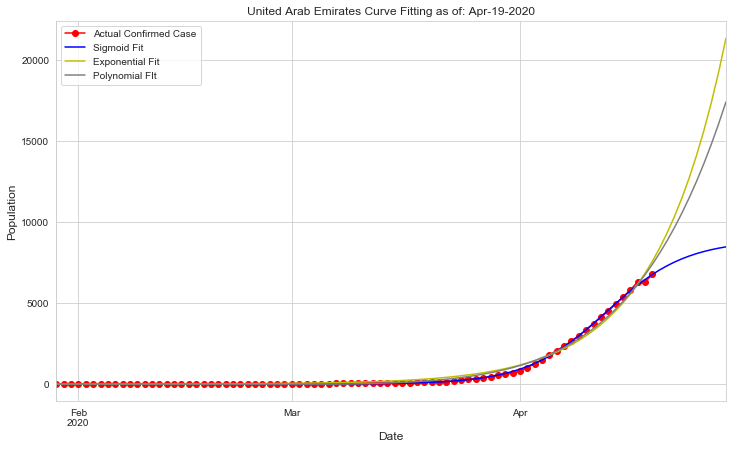

In [11]:
Output_result = plot_curve('United Arab Emirates')

In [8]:
# Output_df = Output_df.append(plot_curve('US'))
# Output_df.to_csv(path_dir+'\\output\\Model1_output.csv',index=False)
Output_result.head()

,Date,Sigmoid_Pred,Exponential_Pred,Polynomial_Pred,Confirmed,Country
0,2020-01-22,0.002091,0.695856,0.0,1.0,US
1,2020-01-23,0.002760,0.834232,0.0,1.0,US
2,2020-01-24,0.003643,1.000125,0.0,2.0,US
3,2020-01-25,0.004809,1.199007,0.0,2.0,US
4,2020-01-26,0.006347,1.437438,0.0,5.0,US


# Previous Approach

In [9]:

# def plynomial_model(x,a,b,c):
#     return a*x**b+c
# def logistic_model(x,a,b,c):
#     return c/(1+np.exp(-(x-b)/a))
# def exponential_model(x,a,b,c):
#     return a*np.exp(b*(x-c)) #US

In [10]:

# def curv_fit(Country,Forecast_day=7,p1=[1,1,1]):
#     country_df = md_[md_['Country/Region']==Country]
#     st_dt = pd.to_datetime('2020-01-21', format='%Y-%m-%d')
#     country_df = country_df.sort_values('Days_since_21st_Jan',ascending=False)
#     x=np.array(country_df.Days_since_21st_Jan)
#     y=np.array(country_df.Confirmed)
#     hold = np.array(list(range(max(x)+1,max(x)+Forecast_day+1)))
#     lim = np.unique(np.array(list(x)+list(hold)))
#     lim = -np.sort(-lim)
#     plt.rcParams['figure.figsize'] = [10, 7]
#     plt.rc('font', size=10)
#     plt.scatter(x,y,label="Real data",color="red")
    
#     if Country == 'China':
#         fit = curve_fit(logistic_model,x,y,p0=[10,100,100000])
#         a,b,c = [x for x in fit[0]]
#         plt.plot(x, logistic_model(x,a,b,c), label="Sigmoid Curve" )
# #         sigmoid_forecast = logistic_model(hold,a,b,c)
#     else:
#         try:
#             fit = curve_fit(logistic_model,x,y,p1)
#             errors = [np.sqrt(fit[1][i][i]) for i in [0,1,2]]
#             a,b,c = [x for x in fit[0]]
#             sigmoid_pred = logistic_model(lim,a,b,c)
#             sigmoid_forecast = logistic_model(hold,a,b,c)
#             plt.plot(lim,sigmoid_pred,label="Sigmoid Curve")
#         except RuntimeError:
#             sigmoid_pred = np.zeros(len(lim))
#             b=0
#             print("Sigmoid Function Note fitted {Out of Bound Error}")
#             pass
#         try:
#             pol_fit = curve_fit(plynomial_model,x,y,p0=[1,2,1])
#             pol_errors = [np.sqrt(pol_fit[1][i][i]) for i in [0,1,2]]
#             pa,pb,pc = [x for x in pol_fit[0]]
#             pol_pred = plynomial_model(lim,pa,pb,pc)
#             pol_forecast = plynomial_model(hold,pa,pb,pc)
#             plt.plot(lim, pol_pred, label="Polynomial Curve" )
#         except RuntimeError:
#             pol_pred = np.zeros(len(lim))
#             print("Plynomial Function Note fitted {Out of Bound Error}")
#             pass
#         try:
#             exp_fit = curve_fit(exponential_model,x,y,p0=[1,1,1])
#             exp_errors = [np.sqrt(exp_fit[1][i][i]) for i in [0,1,2]]
#             ea,eb,ec = [x for x in exp_fit[0]]
#             exp_pred = exponential_model(lim,ea,eb,ec)
#             exp_forecast = exponential_model(hold,ea,eb,ec)
#             plt.plot(lim, exp_pred, label="Exponential Curve" )
#         except RuntimeError:
#             exp_pred = np.zeros(len(lim))
#             print("Exponential Function Note fitted {Out of Bound Error}")
#             pass
#     plt.axvline(x=int(b), color='k', linestyle='--',label="Inflection Line")
#     plt.legend()
#     plt.title(Country + ' Distribution Fitting for COVID19 Confirmed Case')
#     plt.xlabel("Days since 21 January 2020")
#     plt.ylabel("Total number of infected people")
# #     plt.xticks(np.array([pd.to_datetime(st_dt+timedelta(int(i)),format='%Y-%m-%d') for i in x]))
#     plt.show()
    
#     print('Best Fit Sigmoid;','Inflection Date:',st_dt+timedelta(int(b)))
#     print()
#     return print(Forecast_day , 'Days Infected Population Forecast',[int(y) for y in sigmoid_forecast])
  

In [11]:
# curv_fit('United Arab Emirates',5,p1=[10,100,10000])

In [12]:

# def forecast_country_infection(Country,forecast_day):
#     country_df = md_[md_['Country/Region']==Country]
#     st_dt = pd.to_datetime('2020-01-21', format='%Y-%m-%d')
#     country_df = country_df.sort_values('Days_since_21st_Jan',ascending=True)
#     x=np.array(country_df.Days_since_21st_Jan)
#     y=np.array(country_df.Confirmed)
#     forecast_day = list(range(min(x),max(x)+forecast_day))

#     fit = curve_fit(logistic_model,x,y,p0=[10,100,100000])
#     a,b,c = [x for x in fit[0]]
#     pred_infection_sigmoid =  logistic_model(forecast_day,a,b,c)

#     exp_fit = curve_fit(exponential_model,x,y,p0=[1,1,1])
#     ea,eb,ec = [x for x in exp_fit[0]]
#     pred_infection_exponential = exponential_model(forecast_day,ea,eb,ec)

#     forecast_df_2WK = pd.DataFrame(zip(forecast_day,pred_infection_sigmoid,pred_infection_exponential),
#                             columns=['Days_since_21st_Jan','Sigmoid_prediction','Exponential_prediction'])
#     forecast_df_2WK['Country'] = Country

#     return forecast_df_2WK;

# # sigmoid_forecast = logistic_model(hold,a,b,c)


# WIP

In [13]:
# import numpy as np

# def rect(x, B):
#     """
#     create a rectangle function
#     returns a numpy array that is 1 if |x| < w and 0 if |x| > w
#     B is the rectangle width centered at 0
#     x is the number of points in the array
#     """
    
#     B = int(B)
#     x = int(x)
    
#     high = np.ones(B)
#     low1 = np.zeros(int(x/2 - B/2))    
#     x1 = np.append(low1, high)
#     rect = np.append(x1, low1)
    
#     if x > len(rect):
#         rect = np.append(rect, 0)
#     elif x < len(rect):
#         rect = rect[:-1]

#     return rect

In [14]:
# %matplotlib notebook
# import matplotlib.pyplot as plt
# from matplotlib.animation import FuncAnimation

# # constants and x array
# pi = np.pi
# length = 2000
# x = np.linspace(-1, 1, length)

# # create figure and axes 
# fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 6))

# # creating our line objects for the plots
# sinc, = ax1.plot(x, np.sin(x), '-b')
# box, = ax2.plot(x, np.sin(x), '-r')

# def animate(B):
#     """
#     this function gets called by FuncAnimation
#     each time called, it will replot with a different width "B"
    
#     B: rect width
    
#     return:
#         sinc: ydata
#         box: ydata
#     """
    
#     # create our rect object
#     f = rect(len(x), B)
#     box.set_ydata(f)
    
#     # create our sinc object
#     F = (B / length) * np.sin(x * B / 2) / (x * B / 2)
#     sinc.set_ydata(F)
    
#     # adjust the sinc plot height in a loop
#     ax1.set_ylim(np.min(F), np.max(F))
    
#     # format the ax1 yticks
#     plt.setp(ax1, xticks=[-0.25, 0.25], xticklabels=['-1/4', '1/4'],
#              yticks=[0, np.max(F)], yticklabels=['0', 'B={:.2f}'.format((B / length))])
    
#     # format the ax2 xticks to move with the box
#     plt.setp(ax2, yticks=[0, 1], 
#              xticks=[-1, -1 * B / length, 1 * B / length, 1], xticklabels=['-1', '-B/2', 'B/2', '1'])
    
# def init():
#     """
#     initialize the figure
#     """
    
#     ax2.set_ylim(-0.2, 1.1)
#     ax1.set_xlim(-0.25, 0.25)
#     ax2.set_xlim(-1, 1)
#     ax1.axhline(0, color='black', lw=1)
#     ax2.axhline(0, color='black', lw=1)
#     plt.rcParams.update({'font.size':14})
    
#     return sinc, box,

# # the FuncAnimation function iterates through our animate function using the steps array
# step = 10
# steps = np.append(np.arange(10, 1000, step), np.arange(1000, 10, -1 * step))
# ani = FuncAnimation(fig, animate, steps, init_func=init, interval=50, blit=True)
# plt.show()

# References
Reference: <br> http://www.engineeringenotes.com/water-engineering-2/water-quantity/forecasting-of-population-9-methods-water-quantity-water-engineering/16158
<br> https://en.wikipedia.org/wiki/Logistic_distribution
<br> https://en.wikipedia.org/wiki/Exponential_growth